In [12]:
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from data_reader import read_data
from data_preprocessing import preprocess_data
from feature_extractor import extract_features

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = read_data()
data = preprocess_data(data)
data.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0100600000117000001,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000001,2017-04-13,Закупка у единственного поставщика (подрядчика...,1310000.0,1310000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
1,0100600000117000002,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000002,2017-04-13,Закупка у единственного поставщика (подрядчика...,249000.0,249000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
2,0100600000117000003,"Закупки товаров, работ, услуг в соответствии с...",https://zakupki.kontur.ru/0100600000117000003,2017-07-06,Закупка у единственного поставщика (подрядчика...,250000.0,250000.0,RUB,Размещение завершено,2.0,0.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47
3,0100600000117000004,Выполнение работ по ремонту автомобильной доро...,https://zakupki.kontur.ru/0100600000117000004,2017-07-06,Запрос котировок,400300.0,400300.0,RUB,Размещение завершено,2.0,2.0,1.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,1.0,47
4,0100600000117000005,Приобретение и установка спортивного оборудования,https://zakupki.kontur.ru/0100600000117000005,2017-07-10,Запрос котировок,451000.0,451000.0,RUB,Размещение завершено,2.0,1.0,0.0,4720008346,NaN,МЕСТНАЯ АДМИНИСТРАЦИЯ МУНИЦИПАЛЬНОГО ОБРАЗОВАН...,1024702184451,0.0,47


In [4]:
g = data.groupby('SuppliersCount')
data_balanced = g.apply(lambda x: x.head(5000)).sample(frac=1, random_state=42).reset_index(drop=True)
data_balanced.head()

,id,Title,Uri,PublicationDateTimeUTC,ProcedureDisplayName,Amount,RubPrice,CurrencyCode,StatusDisplayName,StatusCode,SuppliersCount,IsWinner,Inn,Kpp,Name,Ogrn,ResultClass,Ogrn1
0,0101200009716000032,Оказание услуг по обслуживанию пассажиров в ВИ...,https://zakupki.kontur.ru/0101200009716000032,2016-12-12,Запрос котировок,499000.00,499000.00,RUB,Размещение завершено,2.0,1.0,0.0,0274151354,NaN,УПРАВЛЕНИЕ ДЕЛАМИ ГЛАВЫ РЕСПУБЛИКИ БАШКОРТОСТАН,1100280037813,0.0,2
1,0111300063217000348,Поставка сухофруктов для пришкольных лагерей,https://zakupki.kontur.ru/0111300063217000348,2017-05-19,Электронный аукцион,89080.00,89080.00,RUB,Размещение завершено,2.0,7.0,1.0,1644068560,NaN,МУНИЦИПАЛЬНОЕ БЮДЖЕТНОЕ ОБЩЕОБРАЗОВАТЕЛЬНОЕ УЧ...,1131644001818,1.0,16
2,0101200009516005909,Электронный аукцион [g000946245/7386g] на прав...,https://zakupki.kontur.ru/0101200009516005909,2016-12-15,Электронный аукцион,2478906.69,2478906.69,RUB,Размещение завершено,2.0,1.0,0.0,0276006472,NaN,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,1030204207440,0.0,2
3,0111200000916000574,"Право заключения государственного контракта, г...",https://zakupki.kontur.ru/0111200000916000574,2016-07-06,Электронный аукцион,1548791.00,1548791.00,RUB,Размещение завершено,2.0,7.0,1.0,1656012756,NaN,ГОСУДАРСТВЕННОЕ АВТОНОМНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,1021603063767,1.0,16
4,0101300006016000004,Текущий ремонт объездной дороги в с. Буруновка...,https://zakupki.kontur.ru/0101300006016000004,2016-06-01,Запрос котировок,499996.00,499996.00,RUB,Размещение завершено,2.0,1.0,0.0,0219001252,NaN,АДМИНИСТРАЦИЯ СЕЛЬСКОГО ПОСЕЛЕНИЯ БУРУНОВСКИЙ ...,1020201253555,0.0,2


In [5]:
data_balanced.groupby('SuppliersCount').size()

SuppliersCount
0.0     5000
1.0     5000
2.0     5000
3.0     5000
4.0     5000
5.0     5000
6.0     5000
7.0     3402
8.0     1746
9.0     1101
10.0     448
11.0     148
12.0      73
13.0      58
14.0      75
15.0      12
16.0      27
17.0       3
18.0       4
19.0       2
20.0       1
dtype: int64

In [6]:
features, _ = extract_features(data_balanced)
features.fillna(0, inplace=True)
features.drop('ResultClass', axis=1, inplace=True)
features.head()

oh CurrencyCode
oh ProcedureDisplayName
oh Ogrn
ng Title
ng ProcedureDisplayName
ng OrgName


,RubPrice,SuppliersCount,Amount,OneHot_CurrencyCode_RUB,OneHot_ProcedureDisplayName_Закрытый аукцион,"OneHot_ProcedureDisplayName_Закупка у единственного поставщика (подрядчика, исполнителя)",OneHot_ProcedureDisplayName_Запрос котировок,"OneHot_ProcedureDisplayName_Запрос котировок на выполнение работ по строительству, реконструкции, капитальному ремонту, а также проектных, изыскательских работ в отношении олимпийских объектов и строительству домов взамен земельных участков и объектов недвижимого имущества, изымаемых",OneHot_ProcedureDisplayName_Запрос предложений,OneHot_ProcedureDisplayName_Конкурс для заключения энергосервисного контракта,...,Ngrams_Name_290,Ngrams_Name_291,Ngrams_Name_292,Ngrams_Name_293,Ngrams_Name_294,Ngrams_Name_295,Ngrams_Name_296,Ngrams_Name_297,Ngrams_Name_298,Ngrams_Name_299
0,499000.00,1.0,499000.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,89080.00,7.0,89080.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2478906.69,1.0,2478906.69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1548791.00,7.0,1548791.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,499996.00,1.0,499996.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
X = features.drop('SuppliersCount', axis=1)
y = features.SuppliersCount
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
np.mean(cross_val_score(XGBRegressor(), X_train, y_train, cv=5, scoring=make_scorer(r2_score), n_jobs=-1))

0.6589810829995763

In [31]:
cat = CatBoostRegressor(verbose=0)
np.mean(cross_val_score(cat, X_train, y_train, cv=5, scoring=make_scorer(r2_score)))

0.7129832634483728

In [32]:
cat = CatBoostRegressor(verbose=0)
np.mean(cross_val_score(cat, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

-2.1168486461452214

In [33]:
cat = CatBoostRegressor(verbose=0)
np.mean(cross_val_score(cat, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

-0.9813254845723941

In [35]:
param_grid = {
    'min_child_weight':[2, 3, 4, 5], 
    'gamma':[i / 10.0 for i in range(1, 4)],  
    'subsample':[i / 10.0 for i in range(9, 11)],
    'colsample_bytree':[i / 10.0 for i in range(9, 11)], 
    'max_depth': [4, 5, 6, 7]
}

xgb_reg= XGBRegressor(n_estimators=100, random_state=42) 

grid = GridSearchCV(xgb_reg, param_grid, cv=5, verbose=10, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 4

{'colsample_bytree': 1.0, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9}
0.735739244684597


In [ ]:
param_grid = {
    'min_samples_leaf': [2, 3, 5, 7, 9, 11, 12],
    'max_features': [200, 300, 400, 'sqrt', 'log2']
}
clf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
optimizer = GridSearchCV(clf, param_grid, scoring='r2', cv=5)
optimizer.fit(X_train, y_train)
optimizer.best_estimator_, optimizer.best_score_

In [ ]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42, max_features=300, min_samples_leaf=2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [9]:
xgb = XGBRegressor(n_estimators=100, random_state=42, colsample_bytree=1.0,
                   max_depth=7, gamma=0.2, min_child_weight=5, subsample=0.9)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [10]:
r2_score(y_test, y_pred)

0.752212177030305

In [11]:
mean_absolute_error(y_test, y_pred)

0.8874952825212516

In [8]:
cat = CatBoostRegressor(verbose=0)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

In [9]:
r2_score(y_test, y_pred)

0.7297346785490764

In [10]:
mean_absolute_error(y_test, y_pred)

0.9525586949475416

In [17]:
xgb = XGBRegressor(n_estimators=100, random_state=42, colsample_bytree=1.0, gamma=0.2,
                      max_depth=7, min_child_weight=3, subsample=0.9)
np.mean(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))

-2.680949062462968

In [18]:
xgb = XGBRegressor(n_estimators=100, random_state=42, colsample_bytree=1.0, gamma=0.2,
                      max_depth=7, min_child_weight=3, subsample=0.9)
np.mean(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1))

-1.0976418305083062

In [9]:
data = {
    #'tree': 0.3764,
    'rf': 0.5998,
    'xgb': 0.7841,
    'gbm': 0.6670,
    'cb': 0.7670
}

Text(0, 0.5, '$R^2$')

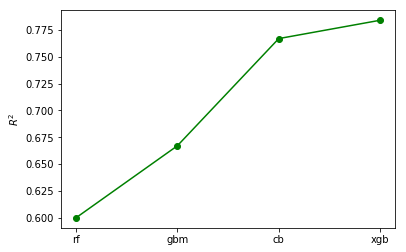

In [10]:
x = sorted(data, key=lambda key: data[key])
y = list(map(lambda key: data[key], x))

#x = ['tree', 'rf', 'xgb', 'lGBM', 'cb']
#y = [0.908333333333, 0.918, 0.918666666667, 0.920333333333]
plt.plot(x, y, 'go-')
plt.ylabel('$R^2$')